In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input,  Reshape
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import load_model
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sns.set_style('white')

In [5]:
np.random.seed(42)
tf.random.set_seed(1234)

In [6]:
#Experiment Path
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [7]:
experiment = 0

In [8]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [9]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

In [10]:
# PREPARE DATA
df = pd.read_csv(r"C:\Users\himan\Desktop\7th GAN\updataDataSets.csv", 
                 index_col='From Date', 
                 parse_dates=['From Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33067 entries, 2019-02-18 00:00:00 to 2022-12-31 00:00:00
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SL NO        33067 non-null  int64  
 1   PM2.5        31251 non-null  float64
 2   PM10         31790 non-null  float64
 3   NO           31396 non-null  float64
 4   NO2          32393 non-null  float64
 5   Nox          32616 non-null  float64
 6   NH3          31705 non-null  float64
 7   SO2          32592 non-null  float64
 8   CO           32616 non-null  float64
 9   Ozone        32473 non-null  float64
 10  Benzene      30961 non-null  float64
 11  Eth-Benzene  16450 non-null  float64
 12  MP-Xylene    22659 non-null  float64
 13  WS           31483 non-null  float64
 14  WD           31528 non-null  float64
 15  SR           20184 non-null  float64
 16  BP           21876 non-null  float64
 17  AT           31462 non-null  float64
 18  RF         

In [11]:
#  Parameters
seq_len = 42
n_seq = 12
batch_size = 148

In [12]:
tickers = ['PM2.5', 'PM10', 'NO', 'NO2', 'Nox', 'NH3','SO2','CO','Ozone','Benzene','Eth-Benzene','MP-Xylene','WS','WD','SR','BP','AT','RF']

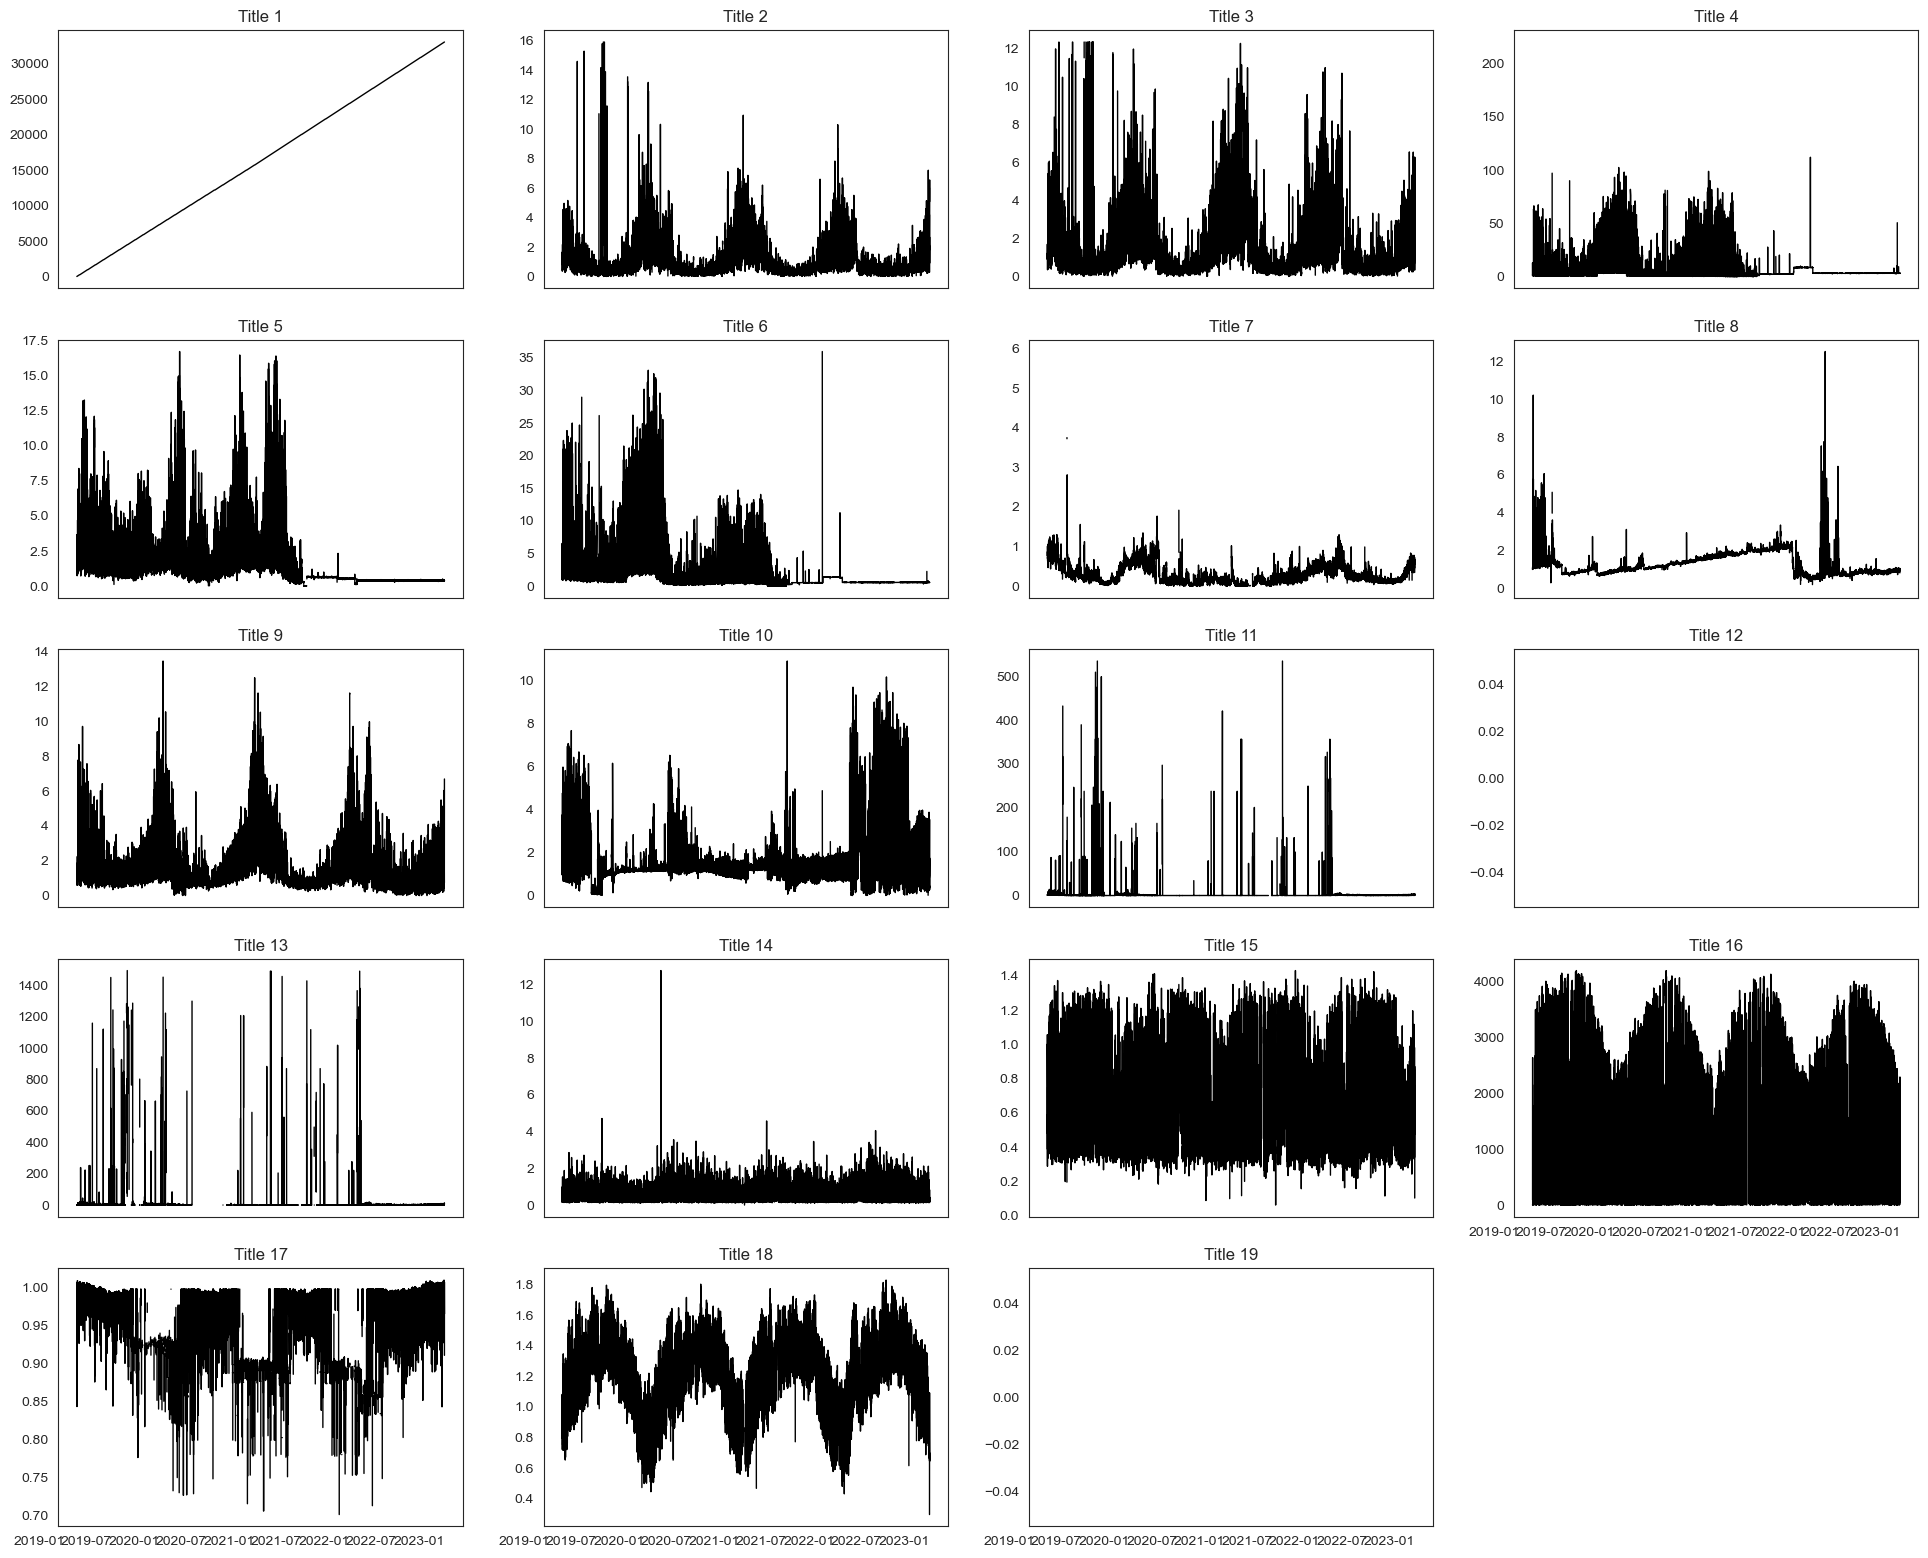

In [13]:
# Plot Series
# Plot Series
axes = df.div(df.iloc[0]).plot(subplots=True,
                               figsize=(24, 22),
                               layout=(5, 4),
                               legend=False,
                               rot=0,
                               lw=1, 
                               color='k')

# Ensure the length of the title list matches the number of columns
titles = [f"Title {i+1}" for i in range(len(df.columns))]

for ax, title in zip(axes.flatten(), titles):
    ax.set_title(title)
    ax.set_xlabel('')




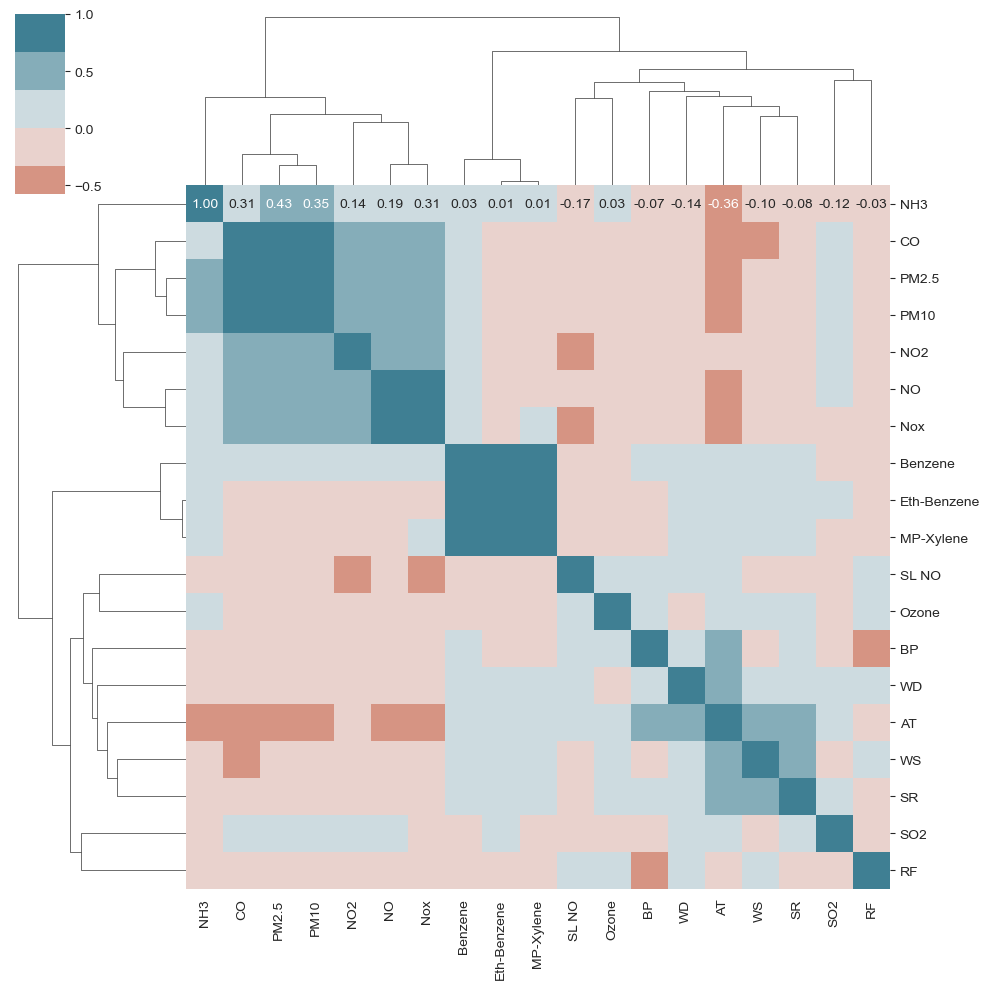

In [14]:
#Correlation
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

In [15]:
#Normalize Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

In [16]:
#Create rolling window sequences
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

In [17]:
#Create tf.data.Dataset
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

In [18]:
#Set up random series generator
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [19]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

In [20]:
# Network Parameters
hidden_dim = 24
num_layers = 3

In [21]:
#Set up logger
writer = tf.summary.create_file_writer(log_dir.as_posix())

In [22]:
#Input place holders
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

In [23]:
# RNN block generator
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

In [24]:
# Embedder & Recovery
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

In [25]:
# Generator & Discriminator
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

In [26]:
# TimeGAN Training
# Settings
train_steps = 10000
gamma = 1

In [27]:
# Generic Loss Functions
mse = MeanSquaredError()
bce = BinaryCrossentropy()

In [28]:
# Phase 1: Autoencoder Training
# Architecture
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [29]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 42, 12)]          0         
                                                                 
 Embedder (Sequential)       (None, 42, 24)            10536     
                                                                 
 Recovery (Sequential)       (None, 42, 12)            11100     
                                                                 
Total params: 21636 (84.52 KB)
Trainable params: 21636 (84.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
autoencoder.save('autoencoder_model.h5')


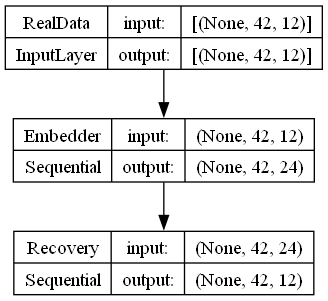

In [31]:
plot_model(autoencoder,
           to_file=(results_path /r"C:\Users\himan\Desktop\7th GAN\autoencoder.png").as_posix(),
           show_shapes=True)

In [32]:
#Autoencoder Optimizer
autoencoder_optimizer = Adam()


In [33]:
#Autoencoder Training Step
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [34]:
input_shape = ( 42, 19)
encoded_dim = 24

input_layer = Input(shape=input_shape)
gru_layer = GRU(72, return_sequences=True)(input_layer)
encoded = Dense(encoded_dim, activation='relu')(gru_layer)
decoded = Dense(input_shape[1], activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Training loop
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        e_loss_0 = tf.reduce_mean(tf.square(x - x_tilde))

    gradients = tape.gradient(e_loss_0, autoencoder.trainable_variables)
    autoencoder.optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))

    return e_loss_0.numpy()

In [ ]:
#Autoencoder Training Loop
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)
    

 17%|█████████████▍                                                               | 1739/10000 [07:04<31:47,  4.33it/s]

In [ ]:
# Phase 2: Supervised training
# Define Optimizer
supervisor_optimizer = Adam()

In [ ]:
#Train Step
@tf.function
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In [ ]:
X_ = next(real_series_iter)
print("Loaded data shape:", X_.shape)



In [ ]:
# Check if X_ has the correct shape before reshaping
if X_.shape == (148, 12):
    X_ = tf.reshape(X_, (1, 148, 12))
else:
    print("Unexpected shape:", X_.shape)


In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    
    # Print the shape before reshaping
    print("Before reshape:", X_.shape)
    
    # Check the total number of elements in the original tensor
    original_elements = tf.reduce_prod(X_.shape)
    
    # Specify the new shape with the same total number of elements
    new_shape = (1, 148, 12)  # Adjust based on your desired shape
    
    # Ensure X_ has the correct total number of elements
    if tf.reduce_prod(new_shape[1:]) == original_elements:
        # Reshape the tensor to the desired shape
        X_ = tf.reshape(X_, new_shape)
        
        # Print the shape after reshaping
        print("After reshape:", X_.shape)
        
        # Ensure X_ has the correct shape for the model
        if X_.shape[1] == 148 and X_.shape[2] == 12:
            step_g_loss_s = train_supervisor(X_)
            with writer.as_default():
                tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)
        else:
            print("Unexpected shape after reshaping:", X_.shape)
    else:
        print("Requested shape has a different number of elements.")


In [ ]:
# Training Loop
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

In [ ]:
# Persist Model
# supervisor.save(log_dir / 'supervisor')

In [ ]:
# Joint Training
# Generator
# Adversarial Architecture - Supervised
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

X_ = tf.reshape(X_, shape=(-1, None, 12))

# Now, X_ should have shape (None, None, 12)

# Continue with your model training
step_g_loss_s = train_supervisor(X_)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [ ]:
adversarial_supervised.summary()

In [ ]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')